# Predicting Time Series Data
> If you want to predict patterns from data over time, there are special considerations to take in how you choose and construct your model.

## This notebook provides recipes for Time Series Prediction (Stock-Prediction): 

*   Input: Given the dataset "prices.txt" which is a comma separated file consisting of the closing price of a certain stock for the past 5 years 
*   Output: Create a "machine learning model" that can accurately predict the most recent 20% prices.

### Models:

 1.   Linear Regression
 2.   LSTM (Long Short-Term Memory)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

## Predicting data over time
- Correlation and regression
    - Regression is similar to calculating correlation, with some key differences
        - Regression: A process that results in a formal model of the data
        - Correlation: A statistic that describes the data. Less information than regression model
- Correlation between variables often changes over time
    - Time series often have patterns that change over time
    - Two timeseries that seem correlated at one moment may not remain so over time.
- Scoring regression models
    - Two most common methods:
        - Correlation ($r$)
        - Coefficient of Determination ($R^2$)
            - The value of $R^2$ is bounded on the top by 1, and can be infinitely low
            - Values closer to 1 mean the model does a better jot of predicting outputs \
       $1 - \frac{\text{error}(model)}{\text{variance}(testdata)}$

In [8]:
data = pd.read_csv('/kaggle/input/time-series-data-prices/prices.txt', parse_dates=['Date']) # convert date column into real date (yyyy-mm-dd)
data.head(10)

,Date,Price
0,2017-02-21,55.478001
1,2017-02-22,54.702000
2,2017-02-23,51.198002
3,2017-02-24,51.400002
4,2017-02-27,49.245998
5,2017-02-28,49.998001
6,2017-03-01,50.004002
7,2017-03-02,50.096001
8,2017-03-03,50.313999
9,2017-03-06,50.242001


In [9]:
data.isnull().sum() # check if data have NaN values

Date     0
Price    0
dtype: int64

#### Split Date column into 3 columns (day, month, year)

In [10]:
data['day'] = data.Date.dt.day
data['month'] = data.Date.dt.month
data['year'] = data.Date.dt.year
data.head(10)

,Date,Price,day,month,year
0,2017-02-21,55.478001,21,2,2017
1,2017-02-22,54.702000,22,2,2017
2,2017-02-23,51.198002,23,2,2017
3,2017-02-24,51.400002,24,2,2017
4,2017-02-27,49.245998,27,2,2017
5,2017-02-28,49.998001,28,2,2017
6,2017-03-01,50.004002,1,3,2017
7,2017-03-02,50.096001,2,3,2017
8,2017-03-03,50.313999,3,3,2017
9,2017-03-06,50.242001,6,3,2017


#### Display Prices vs Date

<AxesSubplot:xlabel='Date'>

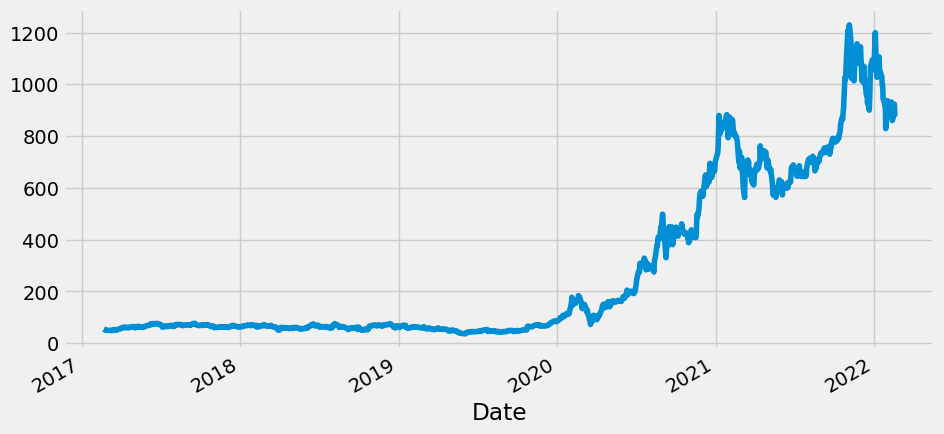

In [11]:
data = data.set_index('Date')
data.Price.plot()

#### Display Prices for each 31th in each month in each year

<AxesSubplot:xlabel='Date'>

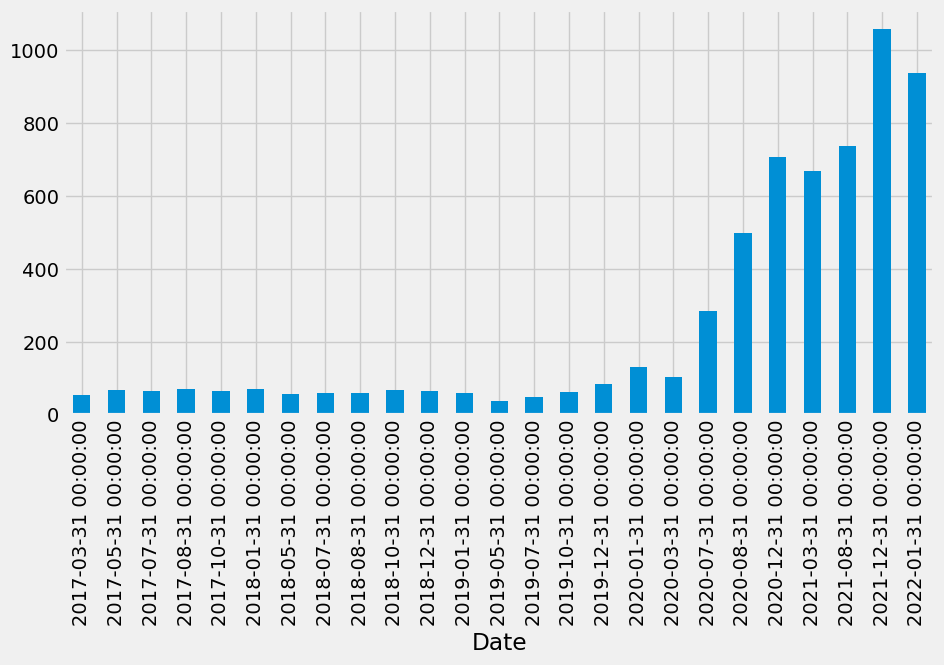

In [12]:
data[data.day==31].Price.plot(kind='bar')

### Feature Engineering

In [13]:
data['Is_month_end'] = data.day.map(lambda x: 1 if x in [28, 30, 31] else 0)
data['Is_month_start'] = data.day.map(lambda x: 1 if x == 1 else 0)
data['Is_year_end'] = data.month.map(lambda x: 1 if x == 12 else 0)
data['Is_year_start'] = data.month.map(lambda x: 1 if x == 1 else 0)
data.head(12)

,Price,day,month,year,Is_month_end,Is_month_start,Is_year_end,Is_year_start
Date,,,,,,,,
2017-02-21,55.478001,21,2,2017,0,0,0,0
2017-02-22,54.702000,22,2,2017,0,0,0,0
2017-02-23,51.198002,23,2,2017,0,0,0,0
2017-02-24,51.400002,24,2,2017,0,0,0,0
2017-02-27,49.245998,27,2,2017,0,0,0,0
2017-02-28,49.998001,28,2,2017,1,0,0,0
2017-03-01,50.004002,1,3,2017,0,1,0,0
2017-03-02,50.096001,2,3,2017,0,0,0,0
2017-03-03,50.313999,3,3,2017,0,0,0,0


In [14]:
def root_mean_squared_error(y_actual, y_pred): # calculate rmse
    return np.sqrt(np.mean(np.power((np.array(y_actual) - np.array(y_pred)), 2)))

## Prediction by Linear Regression Model

Spliting data into `~ 80% train` and `20% test` sets 
#### NOTE: testset is the most recent 20% form data

In [15]:
X_train = data.iloc[:1000][['day', 'month', 'year', 'Is_month_end', 'Is_month_start', 'Is_year_end', 'Is_year_start']].values
y_train = data.iloc[:1000][['Price']].values
X_test = data.iloc[1000:][['day', 'month', 'year', 'Is_month_end', 'Is_month_start', 'Is_year_end', 'Is_year_start']].values
y_test = data.iloc[1000:][['Price']].values

In [16]:
print(f'train x shape: {X_train.shape}')
print(f'train y shape: {y_train.shape}')
print(f'test x shape: {X_test.shape}')
print(f'test y shape: {y_test.shape}')

train x shape: (1000, 7)
train y shape: (1000, 1)
test x shape: (259, 7)
test y shape: (259, 1)


In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

#make predictions and find the root mse
preds = model.predict(X_test)
rms = root_mean_squared_error(np.array(y_test), np.array(preds))
rms

448.4513661831818

## Plotting

Text(0.5, 1.0, 'Linear Regression Model')

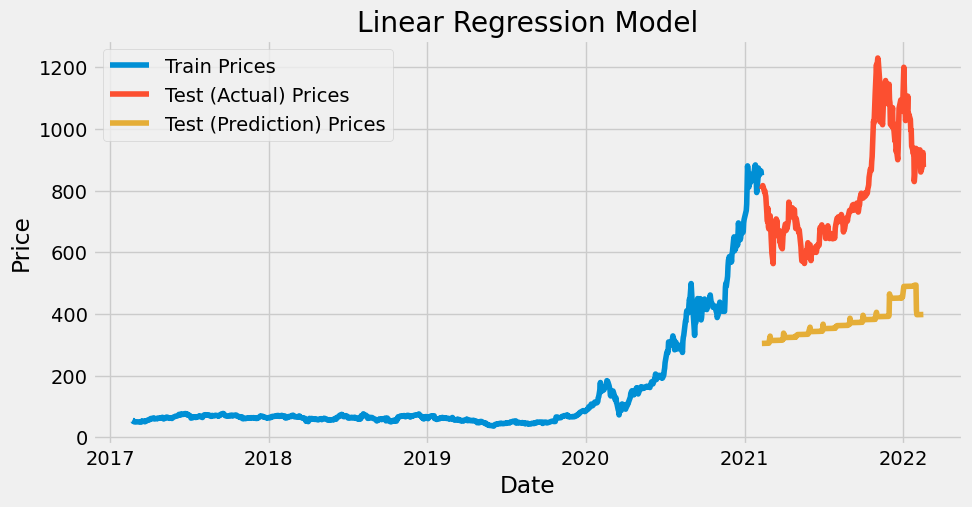

In [19]:
plt.plot(data.iloc[:1000].index, y_train)
plt.plot(data.iloc[1000:].index, y_test)
plt.plot(data.iloc[1000:].index, preds)
plt.legend(['Train Prices', 'Test (Actual) Prices', 'Test (Prediction) Prices'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression Model')

---

## LTSM Model

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

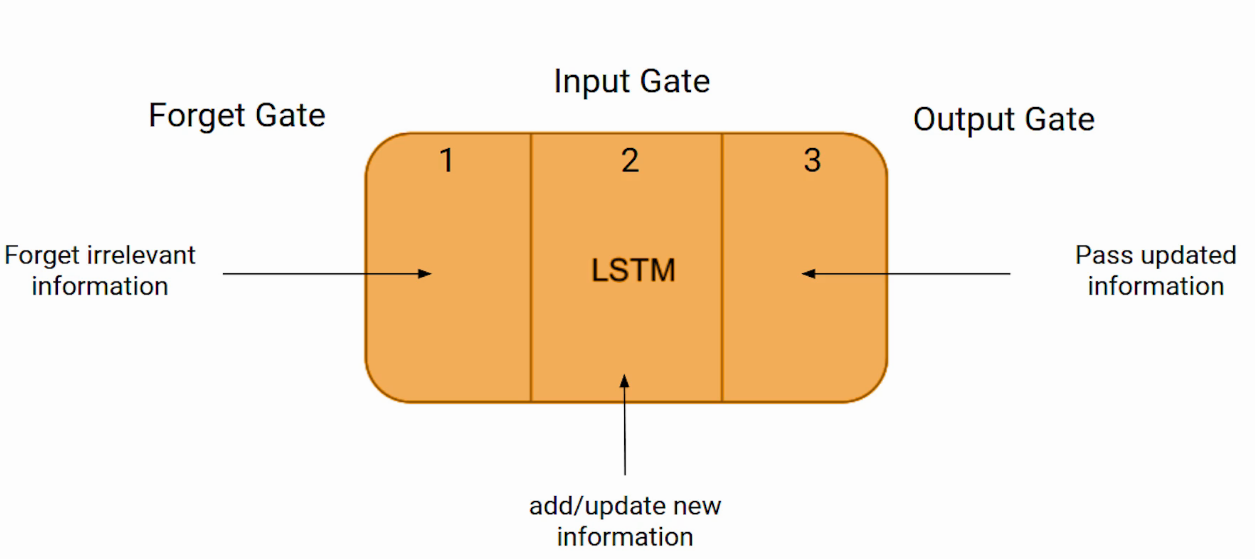

*   **The input gate**: The input gate adds information to the cell state
*   **The forget gate**: It removes the information that is no longer required by the model
*   **The output gate**: Output Gate at LSTM selects the information to be shown as output

### importing necessary libraries

In [20]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### Creating dataframe

In [21]:
data = pd.read_csv('/kaggle/input/time-series-data-prices/prices.txt', parse_dates=['Date']) # convert date column into real date (yyyy-mm-dd)
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(data)), columns=['Date', 'Price'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Price'][i] = data['Price'][i]
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
print(f'[Date & Price onlyyy] ###################')
print(new_data.head())

[Date & Price onlyyy] ###################
                Price
Date                 
2017-02-21  55.478001
2017-02-22     54.702
2017-02-23  51.198002
2017-02-24  51.400002
2017-02-27  49.245998


### Creating train and test sets

In [22]:
dataset = new_data.values

train = dataset[:1000]
test = dataset[1000:]
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (1000, 1)
test shape: (259, 1)


### Converting dataset into x_train and y_train

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
print(f'[Scaled data] ###################')
print(scaled_data.shape)

[Scaled data] ###################
(1259, 1)


In [24]:
past_days = 30
x_train, y_train = [], []
for i in range(past_days, len(train)):
    x_train.append(scaled_data[i - past_days : i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f'train x shape: {x_train.shape}')
print(f'train y shape: {y_train.shape}')

train x shape: (970, 30, 1)
train y shape: (970,)


In [25]:
print(f'[Loading Model] ###################')
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=1)

[Loading Model] ###################
Epoch 1/3
970/970 [==============================] - 15s 13ms/step - loss: 0.0013
Epoch 2/3
970/970 [==============================] - 12s 12ms/step - loss: 6.2197e-04
Epoch 3/3
970/970 [==============================] - 12s 12ms/step - loss: 4.9082e-04


### predicting 246 values, using past 60 from the train data

In [26]:
inputs = new_data[len(new_data) - len(test) - past_days:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(past_days,inputs.shape[0]):
    X_test.append(inputs[i-past_days:i,0])
X_test = np.array(X_test)
print(f'test x shape: {X_test.shape}')
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

test x shape: (259, 30)


In [27]:
preds_price = model.predict(X_test)
preds_price = scaler.inverse_transform(preds_price)

9/9 [==============================] - 1s 8ms/step


In [28]:
rmse = root_mean_squared_error(test, preds_price)
rmse

45.84635907214675

## Plotting

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'LSTM Regression Model')

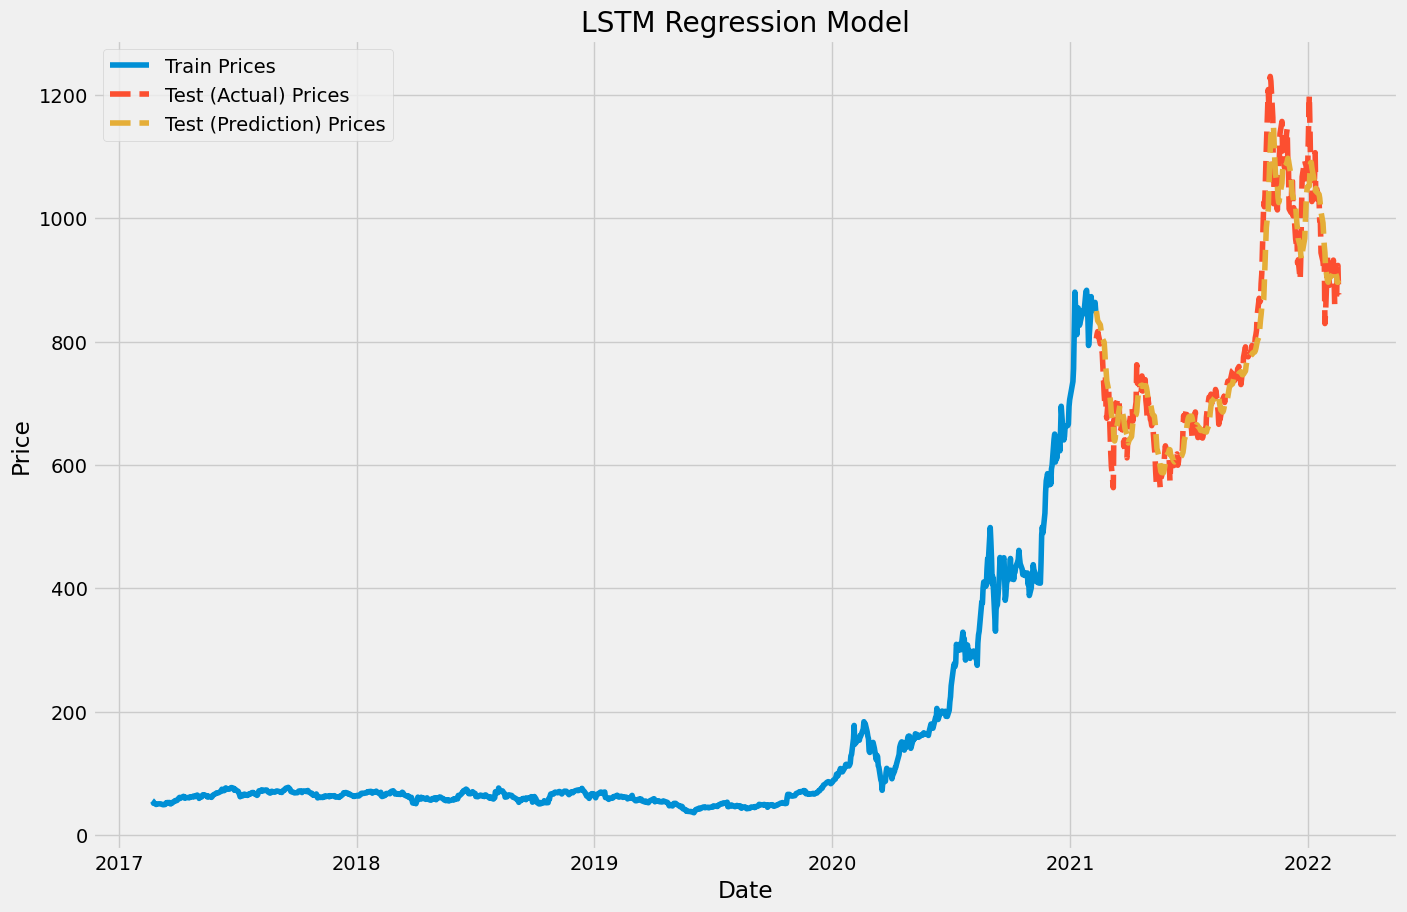

In [29]:
plt.rcParams["figure.figsize"] = (15,10)
train = new_data[:1000]
test = new_data[1000:]
test['Predictions'] = preds_price
plt.plot(train['Price'])
plt.plot(test[['Price','Predictions']] ,linestyle='dashed')
plt.legend(['Train Prices', 'Test (Actual) Prices', 'Test (Prediction) Prices'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM Regression Model')